### Detecting Extreme Events (Wind)

In [1]:
import logging

import matplotlib.pyplot as plt

from jua import JuaClient
from jua.types.geo import LatLon
from jua.weather import Models, Variables

logging.basicConfig(level=logging.INFO)

In [2]:
# Defining the sites that we are interested in
sites = [
    LatLon(55.06, 13.00, label="Kriegers Flak"),
    LatLon(54.04, 5.96, label="Gemini Wind Farm"),
    LatLon(51.71, 2.91, label="Borssele III & IV"),
    LatLon(53.89, 1.79, label="Hornsea Two"),
]

# We want to check if the wind speed exceeds some threshold
variables = [
    Variables.WIND_SPEED_AT_HEIGHT_LEVEL_100M,
]

WINDSPEED_UPPER_THRESHOLD = 40  # m/s
WINDSPEED_LOWER_THRESHOLD = 3  # m/s
TIME_WINDOW = 72  # hours = 3 days

In [3]:
# Setup the client and the model to use
client = JuaClient()
model = client.weather.get_model(Models.EPT1_5)

In [4]:
# Load the latest forecast
print(f"Loading forecast for {len(sites)} sites")
site_forecasts = model.forecast.get_forecast(
    init_time="latest",
    variables=variables,
    points=sites,
    max_lead_time=TIME_WINDOW,
)

Loading forecast for 4 sites


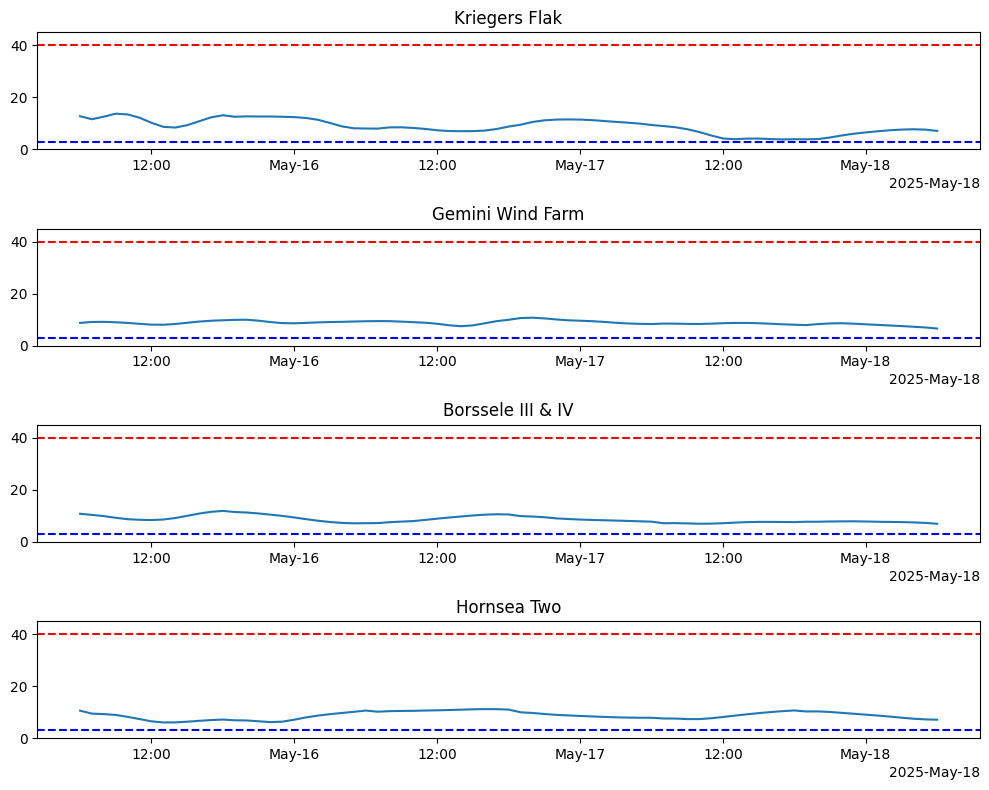

In [5]:
_, axs = plt.subplots(len(sites), 1, figsize=(10, len(sites) * 2))
wind = site_forecasts[Variables.WIND_SPEED_AT_HEIGHT_LEVEL_100M].to_absolute_time()
y_limit = max(WINDSPEED_UPPER_THRESHOLD + 5, wind.max())

for i, site in enumerate(sites):
    site_data = wind.isel(points=i)
    site_data.plot(ax=axs[i])
    axs[i].set_title(site.label)

    # Draw horizontal line at threshold
    axs[i].axhline(WINDSPEED_UPPER_THRESHOLD, color="red", linestyle="--")
    axs[i].axhline(WINDSPEED_LOWER_THRESHOLD, color="blue", linestyle="--")
    # no ylable, no xlabel
    axs[i].set_ylim(0, y_limit)
    axs[i].set_ylabel("")
    axs[i].set_xlabel("")

    # Select dates where wind speed exceeds upper threshold
    time = site_data.absolute_time.values.flatten()
    site_data = site_data.values.flatten()
    upper_threshold_mask = site_data > WINDSPEED_UPPER_THRESHOLD
    upper_threshold_dates = time[upper_threshold_mask]

    # Mark the dates with a vertical line
    for date in upper_threshold_dates:
        axs[i].axvline(date, color="red", linestyle="--")

    lower_threshold_mask = site_data < WINDSPEED_LOWER_THRESHOLD
    lower_threshold_dates = time[lower_threshold_mask]
    for date in lower_threshold_dates:
        axs[i].axvline(date, color="blue", linestyle="--")

plt.tight_layout()
plt.show()